In [1]:
from IPython.display import display
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import copy
import scipy

from matplotlib import rcParams
from scipy.stats import pearsonr, fisher_exact
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys
from sklearn.metrics import roc_auc_score

from misc import rename_cytokines, rename_CMs, rename_factors, rename_Y, make_annot, convert_partial_year, rename_blood, rename_pathways, get_phenotype_contrasts
from misc import coef_col, pval_col, padj_col
from bcg_utils import fisher_enrichment
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8

FDR = [0.05]
TRANSPOSE_ENR_TABLE = True
ENR_FIG_WIDTH, ENR_CELL_HEIGHT = (3, 0.15) if TRANSPOSE_ENR_TABLE else (10, 0.1)
PVAL_ASTERISKS = [0.05, 0.01, 0.001]

# scRNAseq
RNA_MODEL = 'scLM'
INTERACTION = False
REQUIRE_TRIM_ABOVE_D90 = False

RNA_FDR = 0.1
RNA_EPI_P = 0.05
RNA_RESULTS_DIR = os.path.join('results', 'scRNAseq', 'with_log_counts')
ENR_COLS = [rename_ENR_suppl_cols()[col] for col in get_ENR_suppl_cols() if col != 'Term']

VOLCANO_XTICKS = [-0.3, 0, 0.3]
VOLCANO_XLIM = [-0.375, 0.375]

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure7')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'

MODEL_TEMPLATE = 'donor_as_mixed.batch.sex.age.blood.TSS_enr.visit_time.thm.{}_V3_FC1.2_responder'
PHENOTYPE = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'

SWAP_TO_NON_RESP = True

# Suppl. Tables

In [3]:
RNA_DE = 'S0X_scRNAseq_DE'
RNA_ENRICH = 'S0X_scRNAseq_ENRICH'

In [4]:
SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables(
        [RNA_DE, RNA_ENRICH],
        modes=['w', 'w']
    )

### scRNA-seq

In [5]:
contrasts = get_phenotype_contrasts(PHENOTYPE, swap_to_non_resp=SWAP_TO_NON_RESP)
epi_coefs = np.asarray(list(contrasts.keys()))[[2, 0]].tolist()

de_df = misc.read_de(celltype=CELLTYPE, model=MODEL_TEMPLATE.format(PHENOTYPE), contrasts=epi_coefs, annot_fn=misc.PEAK_ANNOT_ALL_FN, swap_to_non_resp=SWAP_TO_NON_RESP)
de_df.head()

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz


,A,Coef.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3,t.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3,p.value.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3,Coef.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R,t.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R,p.value.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R,padj.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3,padj.thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R,chr,...,length,feat_anchor,distance,location,feat_type,gene_id,gene_name,characterization,reg_feature,reg_feature_id
genes,,,,,,,,,,,,,,,,,,,,,
CONS00000000000,1.798203,-0.022578,-0.348953,0.727228,-0.008011,-0.093030,0.925906,0.936710,0.984107,chr1,...,678,start,19382.0,Upstream,gene:lncRNA,ENSG00000243485.5,MIR1302-2HG,intergenic,CTCF_binding_site,ENSR00000344264
CONS00000000002,2.776799,-0.074352,-1.315181,0.188875,0.050434,0.697122,0.485955,0.658446,0.828522,chr1,...,1264,start,7298.0,Downstream,gene:lncRNA,ENSG00000241860.7,AL627309.5,distal,reg_NONE,NaN
CONS00000000004,1.907199,-0.133358,-1.835556,0.066842,-0.188105,-1.947994,0.051809,0.482382,0.403616,chr1,...,1023,start,17742.0,Downstream,gene:lncRNA,ENSG00000241860.7,AL627309.5,intergenic,reg_NONE,NaN
CONS00000000010,4.758521,0.034861,0.514492,0.607079,0.008865,0.100482,0.919992,0.899769,0.982899,chr1,...,1324,start,42711.0,Upstream,gene:lncRNA,ENSG00000235146.2,AC114498.1,intergenic,CTCF_binding_site,ENSR00000249784
CONS00000000013,5.177775,-0.026405,-0.389957,0.696694,-0.119019,-1.317158,0.188240,0.927929,0.622559,chr1,...,908,start,46591.0,Upstream,gene:lncRNA,ENSG00000235146.2,AC114498.1,intergenic,CTCF_binding_site,ENSR00000918325


In [6]:
de_RNA = misc.get_scRNAseq_results(RNA_RESULTS_DIR, model=RNA_MODEL, celltype_cols=CELLTYPE, interaction=INTERACTION, subsample_sorted_cells=False)
rna_genes = de_RNA[RNA_MODEL][CELLTYPE]['pval'].index
rna_genes

Index(['AL627309.1', 'AL627309.5', 'AL627309.4', 'LINC01409', 'LINC01128',
       'LINC00115', 'FAM41C', 'AL645608.2', 'SAMD11', 'NOC2L',
       ...
       'AL357497.1', 'AF131216.5', 'AL356259.1', 'KLHL4', 'AC106028.2',
       'C21orf91-OT1', 'AL358075.1', 'AC004882.3', 'CEND1', 'AC006111.3'],
      dtype='object', length=20856)

In [7]:
BONF = 8
RNA_enr = defaultdict(lambda: [])

epi_hits = defaultdict(lambda: defaultdict(lambda: {}))
rna_hits = defaultdict(lambda: defaultdict(lambda: {}))
background = {}

for region_filter in [
    # misc.TSS_PROXIMAL,
    misc.GENE_AND_DISTAL_10kb
]:
    suppl_df = []
    peaks_and_genes = de_df.loc[utils.peaks_to_genes(de_df, **misc.PEAKS_TO_GENES[region_filter]), 'gene_name']
    peaks_and_genes = peaks_and_genes.str.split(', ', expand=True).stack().rename('gene_name')
    peaks_and_genes.index = peaks_and_genes.index.get_level_values(0)
    background_prev = None 

    for rna_coef in [RNA_D90, RNA_TRIM]:
        for rna_direction in [1, -1]:
            # scRNA-seq
            rna_genes = de_RNA[RNA_MODEL][CELLTYPE]['pval'].index
            assert rna_genes.is_unique

            if CELLTYPE in ['PBMCs', 'PBMC']:
                background[region_filter] = rna_genes.intersection(set(peaks_and_genes))
            else:
                background[region_filter] = rna_genes[de_RNA[RNA_MODEL][CELLTYPE]['expFrac'][rna_coef] > EXP_FRAC].intersection(set(peaks_and_genes))
            if background_prev is None:
                print(CELLTYPE, region_filter, 'background', len(background[region_filter]))
                background_prev = copy.copy(background[region_filter])
            else:
                assert background_prev.equals(background[region_filter])

            rna_LFC = de_RNA[RNA_MODEL][CELLTYPE]['coef'].loc[background[region_filter], rna_coef]
            rna_pval = de_RNA[RNA_MODEL][CELLTYPE]['pval'].loc[background[region_filter], rna_coef]
            rna_padj = misc.adjusted_pvals(rna_pval)
            assert rna_padj.index.equals(rna_LFC.index)
            assert rna_padj.index.isin(background[region_filter]).all()
            
            if RNA_FDR < 1:
                rna_hits[region_filter][rna_coef][rna_direction] = rna_padj.loc[(rna_LFC * rna_direction > 0) & (rna_padj <= RNA_FDR)].index
            else:
                rna_hits[region_filter][rna_coef][rna_direction] = rna_pval.loc[rna_LFC * rna_direction > 0].sort_values().head(RNA_FDR).index
            
            if REQUIRE_TRIM_ABOVE_D90 and rna_coef == RNA_TRIM:
                trim_above_d90_LFC = de_RNA['scLM'][CELLTYPE]['coef'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
                trim_above_d90_pval = de_RNA['scLM'][CELLTYPE]['pval'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
                trim_above_d90_padj = misc.adjusted_pvals(rna_pval)
                trim_above_d90_genes = trim_above_d90_LFC.index[((trim_above_d90_padj <= RNA_FDR) & (trim_above_d90_LFC * rna_direction > 0)) | (trim_above_d90_padj > RNA_FDR)]
                rna_hits[region_filter][rna_coef][rna_direction] = rna_hits[region_filter][rna_coef][rna_direction].intersection(trim_above_d90_genes)

            # ATAC-seq
            for epi_coef in epi_coefs:
                epi_signed_pval = misc.signed_log10_pvals(de_df.loc[peaks_and_genes.index[peaks_and_genes.isin(background[region_filter])]], coef=epi_coef, neg_log10=False)
                for epi_direction in [1, -1]:
                    epi_pval = epi_signed_pval.loc[epi_signed_pval * epi_direction > 0].rename(misc.pval_col(epi_coef)).abs()
                    epi_pval = pd.concat([epi_pval, peaks_and_genes.loc[epi_pval.index]], axis=1)
                    idx = epi_pval.groupby('gene_name')[misc.pval_col(epi_coef)].idxmin().values
                    assert len(idx) == len(set(idx))
                    assert set(peaks_and_genes.loc[idx]) == set(peaks_and_genes.loc[epi_pval.index])
                    epi_pval = epi_pval.loc[idx]
                    assert epi_pval['gene_name'].isin(background[region_filter]).all()

                    if RNA_EPI_P < 1:
                        epi_hits[region_filter][epi_coef][epi_direction] = epi_pval.loc[epi_pval[misc.pval_col(epi_coef)] <= RNA_EPI_P, 'gene_name']
                    else:
                        epi_hits[region_filter][epi_coef][epi_direction] = epi_pval.sort_values(misc.pval_col(epi_coef)).head(RNA_EPI_P)['gene_name']

                    odds_ratio, pval, overlap = utils.fisher_enrichment(pd.Index(epi_hits[region_filter][epi_coef][epi_direction].values), rna_hits[region_filter][rna_coef][rna_direction], background[region_filter])

                    RNA_enr[region_filter].append(
                        [contrasts[epi_coef][0], DIRECTIONS[epi_direction], rna_coef, DIRECTIONS[rna_direction], odds_ratio, pval, None, overlap]
                    )
                    
                    suppl_df.append(
                        [f'{rna_coef} ({DIRECTIONS[rna_direction]})', contrasts[epi_coef][0], DIRECTIONS[epi_direction], odds_ratio, pval, np.clip(pval * BONF, a_min=None, a_max=1), overlap]
                    )
    
    index_cols = [REGION_SET_COL, 'rs_association', COMPARISON_COL, ASSOC_COL]
    RNA_enr[region_filter] = pd.DataFrame.from_records(RNA_enr[region_filter], columns=index_cols + ENR_COLS).set_index(index_cols)
    suppl_df = pd.DataFrame.from_records(suppl_df, columns=[GENE_SET_COL, COMPARISON_COL, ASSOC_COL] + ENR_COLS).set_index([GENE_SET_COL, COMPARISON_COL, ASSOC_COL])
    assert len(RNA_enr[region_filter]) % 2 == 0
    bonf_corr = len(RNA_enr[region_filter]) / len(epi_coefs)
    assert bonf_corr == BONF
    print(f'Bonferroni correction of {bonf_corr}')
    RNA_enr[region_filter].loc[:, PADJ_COL] = np.clip(RNA_enr[region_filter][PVAL_COL].values * bonf_corr, a_min=None, a_max=1)
    display(RNA_enr[region_filter].sort_values(PVAL_COL))
    
    if region_filter == misc.GENE_AND_DISTAL_10kb:
        misc.suppl_table_enrich_LFC_extras(
            suppl_df=suppl_df.loc[suppl_df.index.get_level_values('Comparison') == 'Day 90 vs. day 0 (Resp.)'], phenotype=PHENOTYPE, suppl_tables=suppl_tables, table_name=RNA_ENRICH, fig_n='4',
            info= f'Overlap between differentially expressed genes (FDR < 0.1) and differentially accessible gene-linked regions (P < 0.05, distal mapping) with regards to {IMMUNITY_TYPES[PHENOTYPE]} ({SHORT_IMMUNITY_TYPES[PHENOTYPE]}) phenotype 90 days after BCG vaccination{misc.related_to_fig_str("4G")}.', 
            sheet_name=f'RNA_ATAC_overlap_{SHORT_IMMUNITY_TYPES[PHENOTYPE]}')

PBMC GENE_AND_DISTAL_10kb background 12089
Bonferroni correction of 8.0


/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


Odds ratio  \
Region set               rs_association Comparison                       Association               
Non-R. vs. Resp. (d0)    Negative       LPS day 90 vs. LPS day 0         Positive       2.332136   
                                        Unstim. day 90 vs. unstim. day 0 Negative       1.451404   
Day 90 vs. day 0 (Resp.) Positive       LPS day 90 vs. LPS day 0         Positive       1.450058   
Non-R. vs. Resp. (d0)    Positive       Unstim. day 90 vs. unstim. day 0 Positive       1.378006   
Day 90 vs. day 0 (Resp.) Negative       Unstim. day 90 vs. unstim. day 0 Negative       1.356553   
                                        LPS day 90 vs. LPS day 0         Positive       1.408026   
                         Positive       Unstim. day 90 vs. unstim. day 0 Positive       1.296308   
Non-R. vs. Resp. (d0)    Positive       LPS day 90 vs. LPS day 0         Negative       1.289053   
Day 90 vs. day 0 (Resp.) Positive       Unstim. day 90 vs. unstim. day 0 Negative       1.085587   
                         Negative       LPS day 90 vs. LPS day 0         Negative       1.136073   
Non-R. vs. Resp. (d0)    Positive       Unstim. day 90 vs. unstim. day 0 Negative       1.025710   
                         Negative       Unstim. day 90 vs. unstim. day 0 Positive       0.955283   
Day 90 vs. day 0 (Resp.) Positive       LPS day 90 vs. LPS day 0         Negative       0.944604   
Non-R. vs. Resp. (d0)    Positive       LPS day 90 vs. LPS day 0         Positive       0.870391   
                         Negative       LPS day 90 vs. LPS day 0         Negative       0.811034   
Day 90 vs. day 0 (Resp.) Negative       Unstim. day 90 vs. unstim. day 0 Positive       0.816201   

                                                                                           P-value  \
Region set               rs_association Comparison                       Association                 
Non-R. vs. Resp. (d0)    Negative       LPS day 90 vs. LPS day 0         Positive     3.914726e-16   
                                        Unstim. day 90 vs. unstim. day 0 Negative     9.139985e-06   
Day 90 vs. day 0 (Resp.) Positive       LPS day 90 vs. LPS day 0         Positive     4.097883e-05   
Non-R. vs. Resp. (d0)    Positive       Unstim. day 90 vs. unstim. day 0 Positive     3.283439e-04   
Day 90 vs. day 0 (Resp.) Negative       Unstim. day 90 vs. unstim. day 0 Negative     4.775837e-04   
                                        LPS day 90 vs. LPS day 0         Positive     2.570285e-03   
                         Positive       Unstim. day 90 vs. unstim. day 0 Positive     3.784205e-03   
Non-R. vs. Resp. (d0)    Positive       LPS day 90 vs. LPS day 0         Negative     8.649163e-03   
Day 90 vs. day 0 (Resp.) Positive       Unstim. day 90 vs. unstim. day 0 Negative     1.372381e-01   
                         Negative       LPS day 90 vs. LPS day 0         Negative     1.989896e-01   
Non-R. vs. Resp. (d0)    Positive       Unstim. day 90 vs. unstim. day 0 Negative     3.739760e-01   
                         Negative       Unstim. day 90 vs. unstim. day 0 Positive     6.595182e-01   
Day 90 vs. day 0 (Resp.) Positive       LPS day 90 vs. LPS day 0         Negative     7.096667e-01   
Non-R. vs. Resp. (d0)    Positive       LPS day 90 vs. LPS day 0         Positive     9.252232e-01   
                         Negative       LPS day 90 vs. LPS day 0         Negative     9.312664e-01   
Day 90 vs. day 0 (Resp.) Negative       Unstim. day 90 vs. unstim. day 0 Positive     9.370247e-01   

                                                                                      Adjusted P-value  \
Region set               rs_association Comparison                       Association                     
Non-R. vs. Resp. (d0)    Negative       LPS day 90 vs. LPS day 0         Positive         3.131781e-15   
                                        Unstim. day 90 vs. unstim. day 0 Negative         7.311988e-05   
Day 90 vs. day 0 (Resp.)

GENE_AND_DISTAL_10kb


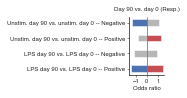

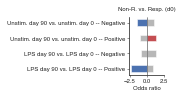

In [8]:
for region_filter in RNA_enr:
    print(region_filter)
    for epi_coef in epi_coefs:
        
        df = RNA_enr[region_filter].loc[RNA_enr[region_filter].index.get_level_values(REGION_SET_COL) == contrasts[epi_coef][0]]
        df, enr_name = misc.format_enrichment_for_plotting(df, sort_lambda=lambda x: 1 if 'LPS' in x else 0)

        misc.plot_enrichment(df, direction_col='rs_association', comparison_col=COMPARISON_COL,
                        value_col=ODDS_RATIO_COL, significance_col=PADJ_COL,
                        significance_thr=np.min(FDR), force_directions=True,
                        title=enr_name, xlabel=ODDS_RATIO_COL, sep_line=True,
                        sep_line_kws=dict(c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth']),
                        figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1] / 7 * 6), height=0.45)
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, f'scRNAseq_enr_{epi_coef}.{region_filter}.svg'))
        plt.show()

In [9]:
if SAVE_TABLES:
    for comparison, sheet_name, cmp_description in [
        (RNA_D90, 'RNA_d90_RPMI_vs_d0_RPMI', 'BCG-induced changes in gene expression'),
        (RNA_TRIM, 'RNA_d90_LPS_vs_d0_LPS', 'BCG-induced changes in gene expression response to LPS stimulation'),
        (RNA_TRIM_ABOVE_BCG, 'RNA_d90_LPS_vs_d90_RPMI', 'LPS-induced changes in gene expression')
    ]:
        suppl_df = misc.suppl_table_rna_seq_LFC(
            de_RNA_dict=de_RNA[RNA_MODEL][CELLTYPE], background=background[misc.GENE_AND_DISTAL_10kb],
            comparison=comparison, cmp_description=cmp_description, suppl_tables=suppl_tables,
            sheet_name=sheet_name, table_name=RNA_DE, fig_n='4F'
        )
        display(suppl_df.head())
        print(len(suppl_df))

,,Log2 fold change,T-value,P-value,Adjusted P-value
Gene,Comparison,,,,
ATP5F1E,Unstim. day 90 vs. unstim. day 0,-0.124353,-21.158205,3.082506e-99,3.726441e-95
COX7C,Unstim. day 90 vs. unstim. day 0,-0.110270,-16.294655,1.190999e-59,7.198996e-56
TMA7,Unstim. day 90 vs. unstim. day 0,-0.102853,-16.240022,2.902322e-59,1.169539e-55
OST4,Unstim. day 90 vs. unstim. day 0,-0.097918,-15.922537,4.845274e-57,1.464363e-53
COMMD6,Unstim. day 90 vs. unstim. day 0,-0.100442,-15.130028,1.106260e-51,2.674715e-48


12089


,,Log2 fold change,T-value,P-value,Adjusted P-value
Gene,Comparison,,,,
CRIP1,LPS day 90 vs. LPS day 0,0.101516,11.203861,3.992903e-29,4.827020e-25
LRRFIP1,LPS day 90 vs. LPS day 0,0.081065,11.055851,2.098428e-28,1.268395e-24
EZR,LPS day 90 vs. LPS day 0,0.088306,10.760792,5.374327e-27,2.165675e-23
TNIP3,LPS day 90 vs. LPS day 0,-0.050964,-10.719746,8.380776e-27,2.532880e-23
AHNAK,LPS day 90 vs. LPS day 0,0.066454,10.451635,1.465191e-25,3.542539e-22


12089


,,Log2 fold change,T-value,P-value,Adjusted P-value
Gene,Comparison,,,,
MX1,LPS day 90 vs. unstim. day 90,2.160627,337.999657,0.0,0.0
ISG15,LPS day 90 vs. unstim. day 90,2.264957,314.741399,0.0,0.0
IFIT3,LPS day 90 vs. unstim. day 90,2.028709,302.638656,0.0,0.0
IFIT1,LPS day 90 vs. unstim. day 90,1.667722,277.450625,0.0,0.0
IFI6,LPS day 90 vs. unstim. day 90,1.505985,246.191188,0.0,0.0


12089


In [10]:
region_filter = misc.GENE_AND_DISTAL_10kb
epi_coef = 'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3'
d90_epi_rna_shared, trim_epi_rna_shared, trim_above_d90_epi_rna_shared = {}, {}, {}

for direction in [1, -1]:
    d90_epi_genes = pd.Index(epi_hits[region_filter][epi_coef][direction].values)
    d90_rna_genes = rna_hits[region_filter][RNA_D90][direction]
    trim_rna_genes = rna_hits[region_filter][RNA_TRIM][direction]
    # Keep only those that are also higher/lower than T3m_RPMI
    trim_above_d90_LFC = de_RNA['scLM'][CELLTYPE]['coef'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
    trim_above_d90_pval = de_RNA['scLM'][CELLTYPE]['pval'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
    trim_above_d90_padj = misc.adjusted_pvals(rna_pval)
    trim_above_d90_genes = trim_above_d90_LFC.index[(trim_above_d90_padj <= RNA_FDR) & (trim_above_d90_LFC * direction > 0)]
    trim_above_d90_genes = trim_above_d90_genes.intersection(trim_rna_genes)

    print("UP:" if direction > 0 else "DOWN:", "d90_epi_genes", len(d90_epi_genes), '|', "d90_rna_genes", len(d90_rna_genes), '|', "trim_rna_genes", len(trim_rna_genes), '|', "trim_above_d90_genes", len(trim_above_d90_genes))

    d90_epi_rna_shared[direction] = d90_epi_genes.intersection(d90_rna_genes)
    trim_epi_rna_shared[direction] = d90_epi_genes.intersection(trim_rna_genes)
    trim_above_d90_epi_rna_shared[direction] = d90_epi_genes.intersection(trim_above_d90_genes)
    
joblib.dump(d90_epi_rna_shared, os.path.join(RNA_RESULTS_DIR, 'd90_epi_rna_shared.pckl'))
joblib.dump(trim_epi_rna_shared, os.path.join(RNA_RESULTS_DIR, 'trim_epi_rna_shared.pckl'))
joblib.dump(trim_above_d90_epi_rna_shared, os.path.join(RNA_RESULTS_DIR, 'trim_above_d90_epi_rna_shared.pckl'))

UP: d90_epi_genes 2560 | d90_rna_genes 634 | trim_rna_genes 645 | trim_above_d90_genes 236
DOWN: d90_epi_genes 1316 | d90_rna_genes 1217 | trim_rna_genes 503 | trim_above_d90_genes 257


['results/scRNAseq/with_log_counts/trim_above_d90_epi_rna_shared.pckl']

In [11]:
if SAVE_TABLES:
    epi_idx = epi_hits[region_filter][epi_coef][1][epi_hits[region_filter][epi_coef][1].isin(trim_above_d90_epi_rna_shared[1])]
    epi_potent_df = de_df.loc[epi_idx.index, misc.pval_col(epi_coef)]
    epi_potent_df.index = epi_idx.values
    epi_potent_df.index.name = GENE_COL
    epi_potent_df = epi_potent_df.sort_values()

    _df = de_RNA[RNA_MODEL][CELLTYPE]['pval'][[RNA_TRIM, RNA_TRIM_ABOVE_BCG]].loc[epi_potent_df.index]
    _df.columns = 'scRNA-seq: ' + _df.columns
    epi_potent_df = pd.concat([epi_potent_df.rename('ATAC-seq: day 90 vs. day 0 (Resp.)'), _df], axis=1)
    display(epi_potent_df.head())
    epi_potent_df = misc.suppl_table_rna_seq_epi_potent(
        epi_potent_df, description='Genes with increased epigenetic potential 90 days after BCG vaccination',
        suppl_tables=suppl_tables, sheet_name='epi_potential_UP_d90', table_name=RNA_DE, fig_n='4H'
    )

,ATAC-seq: day 90 vs. day 0 (Resp.),scRNA-seq: LPS day 90 vs. LPS day 0,scRNA-seq: LPS day 90 vs. unstim. day 90
Gene,,,
SMG1,0.000214,0.000113,4.669715e-17
PSMA4,0.000313,0.005744,2.587711e-51
RIPK1,0.000781,0.001309,2.351345e-291
SETX,0.000818,0.000243,1.182220e-33
SRSF2,0.001352,0.000009,9.998970e-01


In [13]:
# SOME GENES TO SHARE WITH THOMAS

# df = []
# for direction in [1, -1]:
#     print(direction, 'd90_epi_rna_shared', len(d90_epi_rna_shared[direction]))
#     print(direction, 'trim_epi_rna_shared', len(trim_epi_rna_shared[direction]))
#     print(direction, 'trim_above_d90_epi_rna_shared', len(trim_above_d90_epi_rna_shared[direction]))
#     x = de_df.loc[misc.peaks_to_genes(de_df, **misc.PEAKS_TO_GENES[misc.GENE_AND_DISTAL_10kb])]
#     x = x.loc[x[coef_col(epi_coef)] * direction > 0]
#     x = x.loc[x.groupby('gene_name')[pval_col(epi_coef)].idxmin().values, ['gene_name', pval_col(epi_coef)]]
#     x.index = x['gene_name']
#     assert x.index.is_unique
#     df.append(x.loc[d90_epi_rna_shared[direction], pval_col(epi_coef)].sort_values().rename(
#         f'{"UP" if direction > 0 else "DOWN"}_d90_epi_rna_shared'))
#     df[-1].loc[:] = df[-1].index
#     df[-1] = df[-1].reset_index(drop=True)
    
#     df.append(x.loc[trim_epi_rna_shared[direction], pval_col(epi_coef)].sort_values().rename(
#         f'{"UP" if direction > 0 else "DOWN"}_trim_epi_rna_shared'))
#     df[-1].loc[:] = df[-1].index
#     df[-1] = df[-1].reset_index(drop=True)
    
#     df.append(x.loc[trim_above_d90_epi_rna_shared[direction], pval_col(epi_coef)].sort_values().rename(
#         f'{"UP" if direction > 0 else "DOWN"}_trim_above_d90_epi_rna_shared'))
#     df[-1].loc[:] = df[-1].index
#     df[-1] = df[-1].reset_index(drop=True)
    
# df = pd.concat(df, axis=1)
# df.to_csv('genes.csv')

In [14]:
# THIS IS SLOW

# LIBRARY = {}
# for lib in [f'{KEGG}_min15_max500.gmt', f'{GO_BIO_PROCESS}_min15_max500.gmt']:
#     LIBRARY[lib] = [
#         (lib, utils.gene_set_library(
#             os.path.join('metadata', 'gene_set_libraries', lib),
#             description_NA=None, as_arrays=True, assert_upper=False, make_upper=True))
#     ]
    
# enr_contrasts = ['d90_epi_rna_shared', 'trim_epi_rna_shared', 'trim_above_d90_epi_rna_shared']
# for lib in LIBRARY:
#     enr_df = defaultdict(lambda: {})
#     terms = []
#     for direction in [1, -1]:
#         for degs, name in zip(
#             [
#                 d90_epi_rna_shared[direction],
#                 trim_epi_rna_shared[direction],
#                 trim_above_d90_epi_rna_shared[direction]
#             ],
#             enr_contrasts
#         ):
#             enr_df[direction][name] = utils.gene_set_enrichment_test(
#                 top_genes=degs,
#                 gene_set_libraries=LIBRARY[lib],
#                 background=background[region_filter],
#                 check_background=True,
#                 adjust_gene_sets_to_background=True,
#                 min_gs=15, max_gs=500
#             ).set_index('Term')

#             terms.extend(list(enr_df[direction][name].index[enr_df[direction][name]['Adjusted P-value'] < 0.05]))

#     ax, results, enr_df = misc.enr_heatmap(
#         library=lib, top_n=None, region_filter=region_filter, method=None,
#         enr_df=enr_df.copy(), terms=set(terms),
#         celltype=None, model=None, contrasts=enr_contrasts,
#         pthw_fdr_or_top_n=None, pval_asterisks=PVAL_ASTERISKS,
#         sort_by_n_column=-1,
#         sort_ascending=False, #, force_index=terms,
#         fmt='.0e', annot_size=SMALL_FONT, rename_pthw=True,
#         transpose=TRANSPOSE_ENR_TABLE, fig_width=ENR_FIG_WIDTH, cell_height=ENR_CELL_HEIGHT,
#         # heatmap_kws=dict(vmax=vmax, vmin=vmin, lw=0.5),
#         cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'),
#         save_fig=False, show_fig=False, fig_format='svg')
#     utils.savefig(os.path.join(fig_dir, f'ENR_epi_rna_shared.{lib}.svg'))
#     plt.show()
#     joblib.dump(dict(enr_df), os.path.join(RNA_RESULTS_DIR, f'ENR_trim_above_d90_epi_rna_shared.{lib}.pckl'))

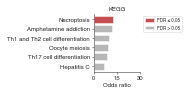

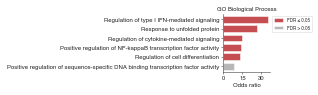

Odds ratio  \
Library                    Gene set                                           Comparison                              Association               
KEGG_2019_Human            Necroptosis                                        Epigenetic potential (day 90 vs. day 0) Positive      12.447851   
GO_Biological_Process_2018 positive regulation of NF-kappaB transcription ... Epigenetic potential (day 90 vs. day 0) Positive      13.516297   
                           regulation of type I interferon-mediated signal... Epigenetic potential (day 90 vs. day 0) Positive      35.032070   
                           regulation of cytokine-mediated signaling pathway  Epigenetic potential (day 90 vs. day 0) Positive      14.667892   
                           response to unfolded protein                       Epigenetic potential (day 90 vs. day 0) Positive      26.258746   

                                                                                                                                    P-value  \
Library                    Gene set                                           Comparison                              Association             
KEGG_2019_Human            Necroptosis                                        Epigenetic potential (day 90 vs. day 0) Positive     0.000092   
GO_Biological_Process_2018 positive regulation of NF-kappaB transcription ... Epigenetic potential (day 90 vs. day 0) Positive     0.000064   
                           regulation of type I interferon-mediated signal... Epigenetic potential (day 90 vs. day 0) Positive     0.000143   
                           regulation of cytokine-mediated signaling pathway  Epigenetic potential (day 90 vs. day 0) Positive     0.000252   
                           response to unfolded protein                       Epigenetic potential (day 90 vs. day 0) Positive     0.000310   

                                                                                                                                   Adjusted P-value  \
Library                    Gene set                                           Comparison                              Association                     
KEGG_2019_Human            Necroptosis                                        Epigenetic potential (day 90 vs. day 0) Positive             0.008402   
GO_Biological_Process_2018 positive regulation of NF-kappaB transcription ... Epigenetic potential (day 90 vs. day 0) Positive             0.038056   
                           regulation of type I interferon-mediated signal... Epigenetic potential (day 90 vs. day 0) Positive             0.042550   
                           regulation of cytokine-mediated signaling pathway  Epigenetic potential (day 90 vs. day 0) Positive             0.046255   
                           response to unfolded protein                       Epigenetic potential (day 90 vs. day 0) Positive             0.046255   

                                                                                                                                  Overlap  
Library                    Gene set                                           Comparison                              Association          
KEGG_2019_Human            Necroptosis                                        Epigenetic potential (day 90 vs. day 0) Positive      5/107  
GO_Biological_Process_2018 positive regulation of NF-kappaB transcription ... Epigenetic potential (day 90 vs. day 0) Positive       5/99  
                           regulation of type I interferon-mediated signal... Epigenetic potential (day 90 vs. day 0) Positive       3/24  
                           regulation of cytokine-mediated signaling pathway  Epigenetic potential (day 90 vs. day 0) Positive       4/72  
                           response to unfolded protein                       Epigenetic potential (day 90 vs. day 0) Positive       3/31

In [15]:
suppl_dict = {}
for lib in [f'{KEGG}_min15_max500.gmt', f'{GO_BIO_PROCESS}_min15_max500.gmt']:
    enr_df = joblib.load(os.path.join(RNA_RESULTS_DIR, f'ENR_trim_above_d90_epi_rna_shared.{lib}.pckl'))
    show_only_top_n = 6
    df = enr_df[1]['trim_above_d90_epi_rna_shared'].reset_index()
    df = df.sort_values('P-value', ascending=True)
    df['Term'] = df['Term'].str.replace(' \(GO:[0-9]+\)$', '')
    suppl_dict[lib.split('_min15')[0]] = {1: {epi_coef: df.copy().sort_values('P-value')}}
    if show_only_top_n:
        df = df.head(show_only_top_n)
    df = df.sort_values('Odds Ratio', ascending=False)
    
    colors = np.asarray([LIGHT_GRAY] * df.shape[0])
    colors[df['Adjusted P-value'] < np.min(FDR)] = RED
    fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0] / 1.5, FIG_SIZE[1] / 7 * 6))
    _barh = plt.barh(y=rename_pathways(df['Term'][::-1]), width=df['Odds Ratio'].values[::-1],
                     height=0.738, color=colors[::-1],
                     edgecolor='w') # mpl.rcParams['lines.linewidth'] / 2
    ax.set_xlabel('Odds ratio')
    ax.tick_params(axis='y', which='both') #, labelsize=SMALL_FONT)
    ax.set_xticks([0, 15, 30])
    ax.set_title('{}'.format(' '.join(lib.split('_201')[0].split('_'))), pad=3)
    handles, labels = [], []
    if not all([c == LIGHT_GRAY for c in colors]):
        handles.append(_barh[-1])
        labels.append('FDR {} {}'.format(utils.LESS_EQUAL, np.min(FDR)))
    if LIGHT_GRAY in colors:
        handles.append(_barh[0])
        labels.append('FDR {} {}'.format('>', np.min(FDR)))
    plt.legend(handles, labels, bbox_to_anchor=(1, 1), fontsize=SMALL_FONT)
    sns.despine()
    _ylim_offset = 0.6125
    ax.set_ylim(-_ylim_offset, df.shape[0] - 1 + _ylim_offset)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'trim_above_d90_epi_rna_shared.{}.{}.svg'.format(lib, region_filter)))
    plt.show()
    
if SAVE_TABLES:
    suppl_df = misc.suppl_table_enrich_LFC(suppl_dict, contrasts={epi_coef: ('Epigenetic potential (day 90 vs. day 0)', 'epi_potential_UP_d90', None)}, phenotype=PHENOTYPE, method='enrichr', limit_FDR=None,
                                           promoters=False, suppl_tables=suppl_tables, table_name=RNA_ENRICH, fig_n='4I',
                                           info=f'Gene set enrichment for genes with increased epigenetic potential 90 days after BCG vaccination{misc.related_to_fig_str("4I")}.',
                                          sheet_name='epi_potential_UP_d90')
    display(suppl_df.head())

In [16]:
g = enr_df[1]['trim_above_d90_epi_rna_shared'].loc[enr_df[1]['trim_above_d90_epi_rna_shared']['Adjusted P-value'] < 0.05, 'Genes'].values
gs = set([ggg for gg in g for ggg in gg.split(';')])
gs

{'EIF2AK2',
 'ELF1',
 'HSP90AB1',
 'HSPA9',
 'NLRC5',
 'OPTN',
 'PRKCQ',
 'RIPK1',
 'RUNX3',
 'SINHCAF',
 'TRIM14',
 'UBC',
 'ZBP1'}

highlights: 44
('Unstim. day 90 vs. unstim. day 0', False) UP: epi_genes 2560 | rna_genes 634
('Unstim. day 90 vs. unstim. day 0', False) DOWN: epi_genes 1316 | rna_genes 1217
(-0.3677209294067134, 0.3356398631913865)


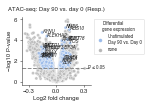

('LPS day 90 vs. LPS day 0', False) UP: epi_genes 2560 | rna_genes 645
('LPS day 90 vs. LPS day 0', False) DOWN: epi_genes 1316 | rna_genes 503
(-0.3677209294067134, 0.3356398631913865)


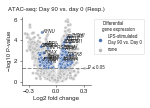

('LPS day 90 vs. LPS day 0', True) UP: epi_genes 2560 | rna_genes 236
('LPS day 90 vs. LPS day 0', True) DOWN: epi_genes 1316 | rna_genes 257
(-0.3677209294067134, 0.3356398631913865)


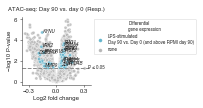

In [17]:
highlights = set(['FOS', 'EIF3A', 'TRAF4', 'IL27RA', 'KLF6', 'LCK', 'ARID4B', 'EIF4A2', 'JUN', 'FOSB', 'SOD1',
                  'FOS', 'EIF3A', 'RIPK1', 'DOCK8', 'REST', 'ZBP1', 'EIF4A2', 'FOSB', 'NR3C1', 'ELF1', 'RUNX3',
                  'RIPK1', 'TRIM14', 'IKZF3', 'KLF6', 'ZBP1', 'ELF1', 'RUNX3', 'IL1RAP', 'ITGAX', 'MSR1', 'PRDM1',
                  'STAT1', 'IRF2', 'GZMB', 'GZMA', 'IFI44', 'STAT4', 'IFI44L', 'NFKBIZ', 'TNFSF13B', 'EREG', 'MMP9',
                  'TNFSF10', 'NFKB1', 'OAS2', 'ITGAX', 'TNIP1', 'GZMB', 'IFITM2', 'IFI44', 'LYN', 'NFKBIA', 'MMP9',
                  'NFKB1', 'IRAK2', 'TRAF1', 'ITGAX', 'MMP9'])
print('highlights:', len(highlights))
epi_coef = epi_coefs[0]

for rna_coef, above_d90, color in [
    (RNA_D90, False, LIGHT_BLUE),
    (RNA_TRIM, False, BLUE),
    (RNA_TRIM, True, CYAN),
]:

    LABELS = {RNA_D90: 'Unstimulated\nDay 90 vs. Day 0', RNA_TRIM: 'LPS-stimulated\nDay 90 vs. Day 0'}
    rna_label = f"{LABELS.get(rna_coef, rna_coef)}{' (and above RPMI day 90)' if above_d90 else ''}"
    de_df['scRNAseq'] = np.nan
    annot_df = []
    trim_above_d90_LFC = {}

    for direction in [1, -1]:
        epi_genes = epi_hits[region_filter][epi_coef][direction]
        rna_genes = rna_hits[region_filter][rna_coef][direction]
        if above_d90:
            # Keep only those that are also higher/lower than T3m_RPMI
            trim_above_d90_LFC[direction] = de_RNA['scLM'][CELLTYPE]['coef'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
            trim_above_d90_pval = de_RNA['scLM'][CELLTYPE]['pval'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
            trim_above_d90_padj = misc.adjusted_pvals(rna_pval)
            trim_above_d90_genes = trim_above_d90_LFC[direction].index[(trim_above_d90_padj <= RNA_FDR) & (trim_above_d90_LFC[direction] * direction > 0)]
            trim_above_d90_LFC[direction] = trim_above_d90_LFC[direction].loc[trim_above_d90_genes]
            rna_genes = rna_genes.intersection(trim_above_d90_genes)

        print((rna_coef, above_d90), "UP:" if direction > 0 else "DOWN:", "epi_genes", len(epi_genes), '|', "rna_genes", len(rna_genes))

        epi_rna_shared = epi_genes.index[epi_genes.isin(rna_genes)]
        de_df.loc[epi_rna_shared, 'scRNAseq'] = rna_label
        # de_df.loc[de_df['gene_name'] == 'NFKB1', 'scRNAseq'] = rna_label
        

    de_df.loc[de_df['scRNAseq'].isnull(), 'scRNAseq'] = 'none'

    annot_df = misc.find_top_hits(
        de_df.loc[de_df['scRNAseq'] != 'none'], epi_coef, max_highlights=6,
        fdr=0.5, show_n=5, unique_genes=True, region_filter=misc.GENE_AND_DISTAL_10kb,
        highlights={epi_coef: highlights.intersection(de_df.loc[de_df['scRNAseq'] != 'none', 'gene_name'])}
    )

    ax = misc.volcano(de_df, contrasts=epi_coef,
                      pval_thr=0.05, fdr=None, fdr_with_hue=False, hue='scRNAseq', sharex=False, sharey=True,
                      fdr_pass_color=None, fdr_fail_color=LIGHT_GRAY, rasterized=RASTER,
                      fdr_prefix='FDR ',
                      legend_kwargs=dict(bbox_to_anchor=(1, 1), title='Differential\ngene expression', markerscale=None, fontsize=SMALL_FONT),
                      scatter_kwargs=dict(linewidth=CIRCLE_LINE_WIDTH),
                      figsize=FIG_SIZE, size=CIRCLE_SIZE * 0.5, alpha=ALPHA, legend=True, centre=False,
                      on_top=de_df.index[de_df['scRNAseq'] != 'none'], on_top_annot=annot_df.index,
                      on_top_shuffle=True, title=contrasts[epi_coefs[0]][0],
                      palette=[color, LIGHT_GRAY],
                      hue_order=[rna_label, 'none']
                     )[0]
    misc.annotate_volcano(ax, annot_df, epi_coef)

    print(ax.get_xlim())
    assert (de_df[misc.coef_col(epi_coef)] <= VOLCANO_XLIM[0]).sum() == 0
    assert (de_df[misc.coef_col(epi_coef)] >= VOLCANO_XLIM[1]).sum() == 0
    ax.set_xlim(VOLCANO_XLIM)
    if VOLCANO_XTICKS:
        ax.set_xticks(VOLCANO_XTICKS)
    ax.set_title(f'ATAC-seq: {contrasts[epi_coef][0]}')

    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'scRNA_volcano_{}.{}.{}{}.svg'.format(PHENOTYPE, epi_coef, rna_coef, '.above_d90)' if above_d90 else '')), dpi=DPI)
    plt.show()

    # de_df.loc[de_df['scRNAseq'] != 'none'].to_csv('TRIM_with_scRNAseq_annot.csv')
    de_df = de_df.drop('scRNAseq', axis=1)

highlights: 44
UP: d90_epi_genes 2560 | d90_rna_genes 634 | trim_rna_genes 645 | trim_above_d90_genes 236
DOWN: d90_epi_genes 1316 | d90_rna_genes 1217 | trim_rna_genes 503 | trim_above_d90_genes 257
(-0.3677209294067134, 0.3356398631913865)


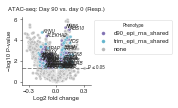

In [18]:
highlights = set(['FOS', 'EIF3A', 'TRAF4', 'IL27RA', 'KLF6', 'LCK', 'ARID4B', 'EIF4A2', 'JUN', 'FOSB', 'SOD1', 'FOS', 'EIF3A', 'RIPK1', 'DOCK8', 'REST', 'ZBP1', 'EIF4A2', 'FOSB', 'NR3C1', 'ELF1', 'RUNX3', 'RIPK1', 'TRIM14', 'IKZF3', 'KLF6', 'ZBP1', 'ELF1', 'RUNX3', 'IL1RAP', 'ITGAX', 'MSR1', 'PRDM1', 'STAT1', 'IRF2', 'GZMB', 'GZMA', 'IFI44', 'STAT4', 'IFI44L', 'NFKBIZ', 'TNFSF13B', 'EREG', 'MMP9', 'TNFSF10', 'NFKB1', 'OAS2', 'ITGAX', 'TNIP1', 'GZMB', 'IFITM2', 'IFI44', 'LYN', 'NFKBIA', 'MMP9', 'NFKB1', 'IRAK2', 'TRAF1', 'ITGAX', 'MMP9'])
print('highlights:', len(highlights))

epi_coef = epi_coefs[0]
de_df['scRNAseq'] = np.nan
annot_df = []
trim_above_d90_LFC = {}
for direction in [1, -1]:
    d90_epi_genes = epi_hits[region_filter][epi_coef][direction]
    d90_rna_genes = rna_hits[region_filter][RNA_D90][direction]
    trim_rna_genes = rna_hits[region_filter][RNA_TRIM][direction]
    # Keep only those that are also higher/lower than T3m_RPMI
    trim_above_d90_LFC[direction] = de_RNA['scLM'][CELLTYPE]['coef'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
    trim_above_d90_pval = de_RNA['scLM'][CELLTYPE]['pval'].loc[background[region_filter], RNA_TRIM_ABOVE_BCG]
    trim_above_d90_padj = misc.adjusted_pvals(rna_pval)
    trim_above_d90_genes = trim_above_d90_LFC[direction].index[(trim_above_d90_padj <= RNA_FDR) & (trim_above_d90_LFC[direction] * direction > 0)]
    trim_above_d90_LFC[direction] = trim_above_d90_LFC[direction].loc[trim_above_d90_genes]
    trim_above_d90_genes = trim_above_d90_genes.intersection(trim_rna_genes)

    print("UP:" if direction > 0 else "DOWN:", "d90_epi_genes", len(d90_epi_genes), '|', "d90_rna_genes", len(d90_rna_genes), '|', "trim_rna_genes", len(trim_rna_genes), '|', "trim_above_d90_genes", len(trim_above_d90_genes))

    d90_epi_rna_shared = d90_epi_genes.index[d90_epi_genes.isin(d90_rna_genes)]
    trim_epi_rna_shared = d90_epi_genes.index[d90_epi_genes.isin(trim_rna_genes)]
    # trim_above_d90_epi_rna_shared = d90_epi_genes.index[d90_epi_genes.isin(trim_above_d90_genes)]
                
    de_df.loc[d90_epi_rna_shared, 'scRNAseq'] = 'd90_epi_rna_shared'
    de_df.loc[trim_epi_rna_shared, 'scRNAseq'] = 'trim_epi_rna_shared'
    
    # annot_df.append(de_df.loc[trim_above_d90_epi_rna_shared].sort_values(pval_col(epi_coef)).head(10))
    
de_df.loc[de_df['scRNAseq'].isnull(), 'scRNAseq'] = 'none'
# annot_df = pd.concat(annot_df)

annot_df = misc.find_top_hits(
    de_df.loc[de_df['scRNAseq'] != 'none'], epi_coef,
    fdr=0.5, show_n=2, unique_genes=True, region_filter=misc.GENE_AND_DISTAL_10kb,
    highlights={epi_coef: highlights}
)


ax = misc.volcano(de_df, contrasts=epi_coef,
                  pval_thr=0.05, fdr=None, fdr_with_hue=False, hue='scRNAseq', sharex=False, sharey=True,
                  fdr_pass_color=None, fdr_fail_color=LIGHT_GRAY, rasterized=RASTER,
                  fdr_prefix='FDR ', legend_kwargs=dict(bbox_to_anchor=(1.8, 1), title=None, markerscale=None, fontsize=SMALL_FONT),
                  scatter_kwargs=dict(linewidth=CIRCLE_LINE_WIDTH),
                  figsize=FIG_SIZE, size=CIRCLE_SIZE * 0.5, alpha=ALPHA, legend=True, centre=False,
                  on_top=de_df.index[de_df['scRNAseq'].isin(['d90_epi_rna_shared', 'trim_epi_rna_shared'])],
                  on_top_shuffle=True,
                  palette=[PURPLE, CYAN, LIGHT_GRAY],
                  hue_order=['d90_epi_rna_shared', 'trim_epi_rna_shared', f'none']
                 )[0]
misc.annotate_volcano(ax, annot_df, epi_coef)

print(ax.get_xlim())
assert (de_df[misc.coef_col(epi_coef)] <= VOLCANO_XLIM[0]).sum() == 0
assert (de_df[misc.coef_col(epi_coef)] >= VOLCANO_XLIM[1]).sum() == 0
ax.set_xlim(VOLCANO_XLIM)
if VOLCANO_XTICKS:
    ax.set_xticks(VOLCANO_XTICKS)
ax.set_title(f'ATAC-seq: {contrasts[epi_coef][0]}')
ax.legend(title='Phenotype', bbox_to_anchor=(1, 1))

if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'scRNA_volcano_{}.{}.svg'.format(PHENOTYPE, epi_coef)), dpi=DPI)
plt.show()

de_df.loc[de_df['scRNAseq'] != 'none'].to_csv('TRIM_with_scRNAseq_annot.csv')
de_df = de_df.drop('scRNAseq', axis=1)

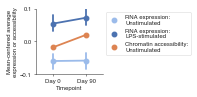

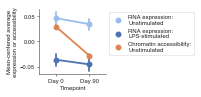

In [19]:
mean_RNAs = joblib.load(os.path.join(RNA_RESULTS_DIR, f'mean_RNAs.pckl'))
mean_ATACs = joblib.load(os.path.join(RNA_RESULTS_DIR, f'mean_ATACs.pckl'))
genes = joblib.load(os.path.join(RNA_RESULTS_DIR, f'trim_above_d90_epi_rna_shared.pckl'))

for direction in genes:
    df = []
    for assay, stim in [('RNA', 'RPMI'), ('RNA', 'LPS'), ('ATAC', 'RPMI')]: 
        for t in ['T0', 'T3m']:
            for g in genes[direction]:
                v = (mean_RNAs if assay == 'RNA' else mean_ATACs[direction])[f'{t}_{stim}'].loc[g]
                df.append([
                    v,
                    f"{'RNA expression' if assay == 'RNA' else 'Chromatin accessibility'}:\n{'LPS-stimulated' if stim == 'LPS' else 'Unstimulated'}",
                    'Day 0' if t == 'T0' else 'Day 90' if t == 'T3m' else 'Error timepoint',
                    assay
                ])
    df = pd.DataFrame.from_records(df, columns=['genes', 'sample', 'Timepoint', 'assay'])
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
    
    sns.pointplot(data=df, x='Timepoint', y='genes', hue='sample', markers=['o', 'o', 'o'], linestyles=['-', '-', '-'],
                  palette=[LIGHT_BLUE, BLUE, ORANGE],
                  dodge=0, ci=90, ax=ax)
    ax.set_ylabel('Mean-centered average\nexpression or accessibility')
    ax.legend(bbox_to_anchor=(1, 1)).set_visible(True)
    if direction == 1:
        ax.set_ylim((-0.1, 0.1))
        ax.set_yticks((-0.1, 0, 0.1))
    sns.despine()
    utils.savefig(os.path.join(fig_dir, 'scRNA_trim_above_d90_epi_rna_shared.{}.svg'.format("UP" if direction > 0 else "DOWN")), dpi=DPI)
    plt.show()

In [20]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S0X_scRNAseq_DE


,Contents
Sheet name,
RNA_d90_RPMI_vs_d0_RPMI,BCG-induced changes in gene expression 90 days...
RNA_d90_LPS_vs_d0_LPS,BCG-induced changes in gene expression respons...
RNA_d90_LPS_vs_d90_RPMI,LPS-induced changes in gene expression 90 days...
epi_potential_UP_d90,Genes with increased epigenetic potential 90 d...


S0X_scRNAseq_ENRICH


,Contents
Sheet name,
RNA_ATAC_overlap_TRIM,Overlap between differentially expressed genes...
epi_potential_UP_d90,Gene set enrichment for genes with increased e...


In [21]:
misc.fix_font_for_suppl_tables(suppl_tables)